#In this problem we aim to implement PCA algorithm from scratch, and then perform a classification task.

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Load Fashion MNIST Dataset from pytorch package and extract it as flat array for PCA algorithm.

In [2]:
#Your code

transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=len(train_dataset), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

train_data, train_labels = next(iter(train_loader))
train_data_flat = train_data.view(train_data.size(0), -1).numpy()
train_labels = train_labels.numpy()

print("Train data shape:", train_data_flat.shape)

test_data, test_labels = next(iter(test_loader))
test_data_flat = test_data.view(test_data.size(0), -1).numpy()
test_labels = test_labels.numpy()

print("Test data shape:", test_data_flat.shape)

#Your code

100%|██████████| 26.4M/26.4M [00:14<00:00, 1.77MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 408kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 2.13MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Train data shape: (60000, 784)
Test data shape: (10000, 784)



# Define PCA function from scratch.
Your function should take the data and the number of reduced dimensions, and return the data with a reduced number of dimensions.

You are only allowed to use NumPy's built-in functions.

In [4]:
#Your code

def Pca(data, k):
    # 1. Centering
    data_centered = data - np.mean(data, axis=0)
    
    # 2. Covariance matrix
    cov_matrix = np.cov(data_centered, rowvar=False)
    
    # 3. eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # 4. sort and choose top k eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_k_indices = sorted_indices[:k]
    top_k_eigenvectors = eigenvectors[:, top_k_indices]
    
    # 5. Encoding
    data_reduced = np.dot(data_centered, top_k_eigenvectors)
    
    return data_reduced, eigenvalues[sorted_indices]
#Your code


### Plot the explained variance as a function of the number of dimensions.

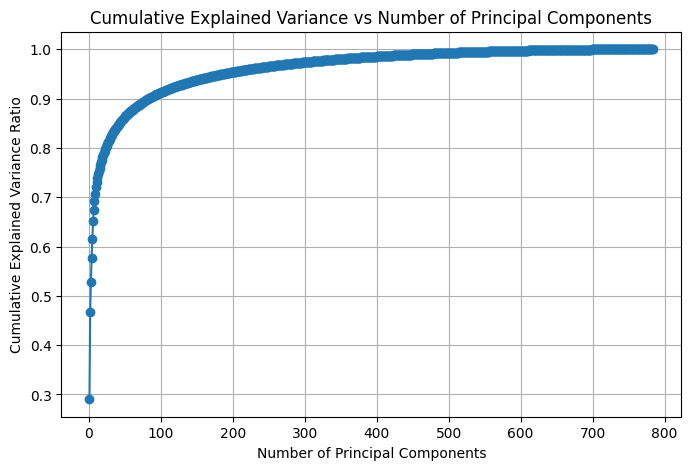

In [6]:
#Your code

_, sorted_eigenvalues = Pca(train_data_flat, 1)
total_variance = np.sum(sorted_eigenvalues)
explained_variance_ratio = sorted_eigenvalues / total_variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title("Cumulative Explained Variance vs Number of Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)

#Your code

In [12]:
for i, value in enumerate(cumulative_explained_variance):
    if value >= 0.8:
        print(i)
        break

23


You can achieve an accuracy higher than 80% with a simple neural network when the number of features is 784. Based on the previous plot, how many features do you think are needed to reach this accuracy?

as we see in the plot  and above code approximately we can say 25 first components is enough

# Now we want to use Scikitlearn package for PCA algorithm.

## Define a function to reduce the number of dimension using Scikitlearn built-in functions.

In [14]:
#Your code
from sklearn.decomposition import PCA
def Pca_SK(data, k):
    pca = PCA(n_components=k)
    data_reduced = pca.fit_transform(data)
    return data_reduced, pca

#Your code

## Define a neural network model to perform a classification task on the Fashion-MNIST dataset.

In [21]:
#Your code

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SimpleFCNN(nn.Module):
    """
    A simple fully connected feedforward neural network for FashionMNIST.
    """
    def __init__(self, input_dim):
        super(SimpleFCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # first fully connected layer
        self.fc2 = nn.Linear(256, 128)     # second fully connected layer
        self.fc3 = nn.Linear(128, 10)      # output layer (10 classes)

    def forward(self, x):
        # x shape: [batch_size, 1, 28, 28]
        # Flatten the image into a 1D vector of size 784
        x = x.view(x.size(0), -1)
        
        # Forward pass
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for features, labels in dataloader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * features.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss  

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100.0 * correct / total

#Your code

Using device: cpu


## Perform a classification task and plot the accuracy as a function of the number of features for the following values: 3, 5, 8, 20, 50, 100, 200, 400, and 784.


=== Using 3 features ===
  Epoch [1/10] | Loss: 1.1014 | Train Acc: 58.70% | Test Acc: 58.30%
  Epoch [2/10] | Loss: 0.9686 | Train Acc: 60.50% | Test Acc: 60.43%
  Epoch [3/10] | Loss: 0.9363 | Train Acc: 62.16% | Test Acc: 62.21%
  Epoch [4/10] | Loss: 0.9155 | Train Acc: 62.84% | Test Acc: 62.87%
  Epoch [5/10] | Loss: 0.9019 | Train Acc: 63.09% | Test Acc: 62.95%
  Epoch [6/10] | Loss: 0.8919 | Train Acc: 62.54% | Test Acc: 61.95%
  Epoch [7/10] | Loss: 0.8848 | Train Acc: 63.71% | Test Acc: 63.49%
  Epoch [8/10] | Loss: 0.8791 | Train Acc: 63.88% | Test Acc: 63.31%
  Epoch [9/10] | Loss: 0.8757 | Train Acc: 63.76% | Test Acc: 63.49%
  Epoch [10/10] | Loss: 0.8727 | Train Acc: 63.03% | Test Acc: 62.57%
Final Test Acc with 3 features: 62.57%

=== Using 5 features ===
  Epoch [1/10] | Loss: 0.9598 | Train Acc: 69.39% | Test Acc: 68.64%
  Epoch [2/10] | Loss: 0.7642 | Train Acc: 71.53% | Test Acc: 70.88%
  Epoch [3/10] | Loss: 0.7351 | Train Acc: 71.64% | Test Acc: 70.95%
  Epoch [4/

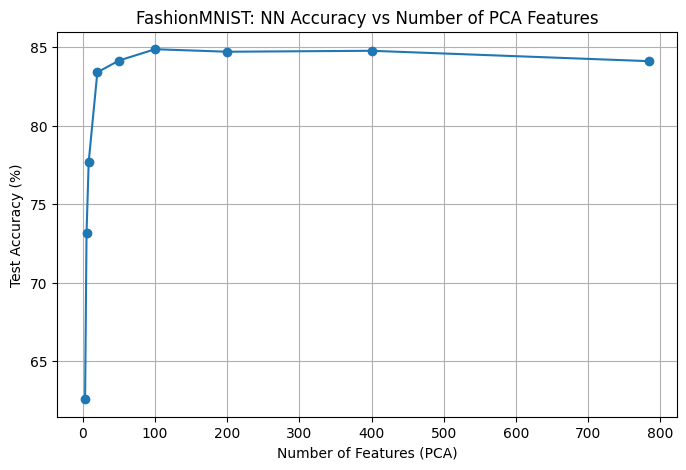

In [23]:
#Your code

feature_dims = [3, 5, 8, 20, 50, 100, 200, 400, 784]
accuracies = []

for k in feature_dims:
    print(f"\n=== Using {k} features ===")
    if k < 784:
        pca = PCA(n_components=k, random_state=42)
        X_train_k = pca.fit_transform(train_data_flat)
        X_test_k = pca.transform(test_data_flat)
    else:
        # k == 784 (use original data)
        X_train_k = train_data_flat
        X_test_k = test_data_flat

    # Convert NumPy arrays -> PyTorch Tensors
    X_train_k_torch = torch.from_numpy(X_train_k).float()
    y_train_torch = torch.from_numpy(train_labels).long()
    X_test_k_torch = torch.from_numpy(X_test_k).float()
    y_test_torch = torch.from_numpy(test_labels).long()

    # Create DataLoader for training set
    train_dataset_k = torch.utils.data.TensorDataset(X_train_k_torch, y_train_torch)
    train_dataloader_k = torch.utils.data.DataLoader(train_dataset_k, batch_size=64, shuffle=True)

    # Create DataLoader for test set
    test_dataset_k = torch.utils.data.TensorDataset(X_test_k_torch, y_test_torch)
    test_dataloader_k = torch.utils.data.DataLoader(test_dataset_k, batch_size=64, shuffle=False)

    # 2. Define Model
    model = SimpleFCNN(input_dim=k).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # 3. Train Model
    for epoch in range(10):
        loss = train_one_epoch(model, train_dataloader_k, criterion, optimizer)
        train_acc = evaluate(model, train_dataloader_k)
        test_acc = evaluate(model, test_dataloader_k)
        print(f"  Epoch [{epoch+1}/{10}] | "
              f"Loss: {loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Test Acc: {test_acc:.2f}%")

    # 4. test
    final_test_acc = evaluate(model, test_dataloader_k)
    accuracies.append(final_test_acc)
    print(f"Final Test Acc with {k} features: {final_test_acc:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(feature_dims, accuracies, marker='o')
plt.title("FashionMNIST: NN Accuracy vs Number of PCA Features")
plt.xlabel("Number of Features (PCA)")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)


#Your code

### Now, what is the minimum number of features needed to achieve accuracy higher than 80 percent?

as we see for first 20 components we achieve this accuracy

### Could you predict this number according to the explained vaiance plot? why?

this plot somehow shows how much information is stored in first k components as a ration of sum of first k eigenvalues to total sum